In [3]:
from __future__ import division
from __future__ import print_function

# data assimilation packages
import numpy as np
import emcee
import cneurons as cn
import quickspikes as qs
import pyspike as spk
import time
from scipy import signal

#plotting packages
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
import pandas as pd             # data analysis and manipulation package
%matplotlib inline

# set up the plots to look not awful
clr_plt = sns.color_palette('cubehelix',4)
sns.set_style('white')
rcParams['figure.figsize'] = (16,10)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


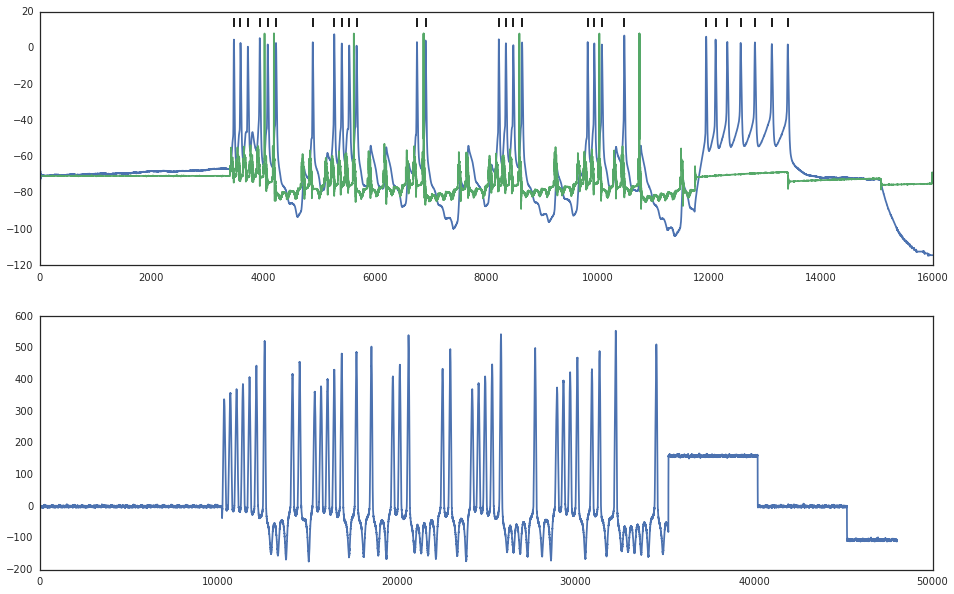

In [4]:
# paths to the voltage and applied current data
vpath = 'neurofit/data/real/20120406_1_3_15v.dat'
ipath = 'neurofit/data/real/20120406_1_3_15i.dat'

# data loading and integrator settings
iscale = 1000
dsample = 3
res = 0.02
dt = 0.06
steps = 16000
maxtau = 150

# spike detector
spikethresh = 0
spikewidth = 10
det = qs.detector(spikethresh, spikewidth)

# load the voltage and applied current data, down-sampling if necessaryv_all = np.loadtxt(vpath)  
# if not dsample else signal.decimate(np.loadtxt(vpath),dsample)
v_all = np.loadtxt(vpath) if not dsample else signal.decimate(np.loadtxt(vpath),dsample)
v = v_all[:steps]
iapp_all = np.loadtxt(ipath)*iscale #if not dsample else signal.decimate(np.loadtxt(ipath)*iscale,dsample)
iapp = iapp_all[:(steps*dt)/res]

# determine in milliseconds the duration of the full voltage data set and the portion used for assimilation
allduration = len(v_all)*dt
duration = len(v)*dt

# create a list of spike times for the full voltage data set and portion used for assimilation
vallspikes = det.send(v_all)
vspikes = det.send(v)

# convert spike times into format used by pyspike
vs = spk.SpikeTrain(vspikes,[0,steps])
vas = spk.SpikeTrain(vallspikes,[0,allduration])


subplot(211)
plot(v)
ade = cn.adex()
ade.h = 8
ade.apply_current(iapp,res)
plot(ade.simulate(duration,dt)[:,0])

vlines(vspikes,max(v)+4,max(v)+9)

subplot(212)
plot(iapp)


In [5]:

def quickGR(chain):             ## gives convergence values. If closer to 1, more converged
    M,N,P = np.shape(chain)
    W = B = 0
    R = np.zeros(P)
    for i in range(0,P):
        W = np.mean(np.var(chain[:,:,i],1,ddof=1))
        B = N*np.var(np.mean(chain[:,:,i],1),ddof=1)
        R[i] = np.sqrt(((1-1/N)*W + B/N)/W)
    return R

# prior probability of the parameters
def lnprior(theta):
    C, gl, el, delt, vt, tw, a, vr, b = theta
 
    # bounds on the uniform prior distributions.
    if (   
            1.0 < C < 500 and 
            0.0  < gl < 30.0 and
            -120 < el < -20 and 
            0.1 < delt < 10 and
            -70 < vt < 0 and
            10 < tw < 210 and
            -10 < a < 10 and  
            -80.0 < vr < 0 and
            0.0 < b < 500
        ):
        
        ''''
        glP = np.log(probsgl[(np.digitize([gl], binsgl))-1]) 
        CP =  np.log(probsC[(np.digitize([C], binsC))-1])
        elP =  np.log(probsel[(np.digitize([el], binsel))-1]) 
        deltP =  np.log(probsdelt[(np.digitize([delt], binsdelt))-1]) 
        '''
        
        print ("0")
        return 0.0
    print -np.inf  
    return -np.inf

# likelihood of the data given the parameters
def lnlike(theta, data, iapp):
    C, gl, el, delt, vt, tw, a, vr, b = theta
    
    # integrating the model with parameters sample
    # Note: Parameters a and b are fixed because they determine spike shape, 
    #       which is irrelevant to the SPIKE sync cost function. I fixed the
    #       parameters to values I know would produce a standard spike shape.
    hrn = cn.adex(C,gl, el, delt, vt, tw, a, vr, b)
    hrn.h = 8
    hrn.apply_current(iapp,res)
    model = hrn.simulate(duration,dt)[:,0]
    
    # estimating the spike times
    mspikes = det.send(model)
    ms = spk.SpikeTrain(mspikes,[0,len(iapp)])
    
    # compare model spike times to spike times fom the real neuron
    # Note: I subtract 1 because emcee expects a negative number and scale
    #       the value by 10000 to make emcee more sensitive to small changes
    #       in the likelihood.
    
    out = np.log(spk.spike_sync(vs,ms,max_tau=maxtau))
    print ('out: ', out)
    #out = -np.sum((data-model)**2)
    
    return  out


# probability of the paramters given the data
def lnprob(theta, y, I):
    
    # calculate prior probability of parameter values
    lp = lnprior(theta)
   
    
    # throw out sample if parameters are out of bounds
    if not np.isfinite(lp):
        return -np.inf
    
    # calculate likelihood of the data given the parameters
    ln = lnlike(theta, y, I)
    
    
    if (ln==ln):
        return lp + ln
    else:
        return -np.inf

    

########################################

In [6]:
### MAIN MCMC CELL ##################################################################################################

# setting the number of walkers
ndim, nwalkers = 9, 500

# setting a starting point in parameter space (ONLY FOR BALL METHOD) 
#start = [ 22.49,   1.98,  -72, 1.29, -51.67,  23.23,  -0.76, -68.35,  49.65]

'''
start = [ 2.20300000e+01, 2.17000000e+00,  -80,   1.10000000e-01,
  -5.32000000e+01,   2.28500000e+01,  -6.00000000e-02,  -6.77900000e+01,
  5.07500000e+01]
'''

# creating a ball of walkers around the starting point
#pos = emcee.utils.sample_ball(start,[2]*len(start),size=nwalkers)

# create walker positions evenly spread across parameter space. Essentially creates starting points from within prior 
# bounds


pos = np.concatenate((np.random.uniform(1.0,500,(nwalkers,1)) ,
                        np.random.uniform(0.0 , 30.0, (nwalkers,1)),
                        np.random.uniform(-120, -20, (nwalkers,1)),
                        np.random.uniform(0.1, 10, (nwalkers,1)),
                        np.random.uniform(-70, 0, (nwalkers,1)),
                        np.random.uniform(10, 210, (nwalkers,1)),
                        np.random.uniform(-10, 10  , (nwalkers,1)),
                        np.random.uniform(-80.0, 0, (nwalkers,1)),
                        np.random.uniform(0,500,(nwalkers,1))),1)


# setting up the sampler to run in parallel on 12 cores
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[v,iapp],threads=8)

'''
%time pos, prob, state = sampler.run_mcmc(pos,500,storechain=True)
maxlik = sampler.flatchain[sampler.flatlnprobability.argmax()]
THIN = int(max(sampler.acor))
print("Thin factor:")
print(THIN)
print("Maximum Likelihood:")
print(maxlik)
print("quickGR:")
print(quickGR(sampler.chain))
print("Acceptance:")
print(np.mean(sampler.acceptance_fraction))
'''

THIN=10


sampler.reset()

# burning in th chains (are these only "burn" values?)
%time pos2, prob, state = sampler.run_mcmc(pos, 20*THIN,storechain=True)
print("Finished burning")
print("quickGR:")
print(quickGR(sampler.chain))
print("Acceptance:")
print(np.mean(sampler.acceptance_fraction))
sampler.reset()

print(" ")

# sampling the posterior distribution of the parameters.
%time pos3, prob2, state2 = sampler.run_mcmc(pos2, 1, storechain=True)
print("Finished Sampling")
print(quickGR(sampler.chain))
print("Acceptance:")
print(np.mean(sampler.acceptance_fraction))


0
0
0
out:  -0.869037847024
0
0
0
0
0
out:  -inf
out:  -inf
0
out:  -3.40119738166
out:  -inf
out:  -inf
0
0
out:  -inf
0
out:  -inf
out:  -2.67414864943
out:  -1.15267950994
out:  -1.41706601979
0
out:  -0.875468737354
0
0
0
0
0
0
out:  -inf
out:  -inf
out:  -2.1400661635
0
out:  -inf
0
out:  -inf
0
out:  -inf
0
0
0
0
out:  -inf
out:  -inf
out:  -inf
out:  -0.810930216216
out:  -inf
0
0
0
out:  -inf
0
0
out:  -inf
out:  -0.792238083204
out:  -inf
out:  -inf
out:  -0.810930216216
out:  -inf
0
0
0
0
out:  -1.41706601979
0
0
0
out:  -inf
out:  -2.67414864943
out:  -inf
out:  -inf
0
out:  -1.64222773526
0
out:  -inf
0
out:  -1.64222773526
0
0
0
0
out:  -2.01490302054
0
out:  -inf
out:  -inf
out:  -inf
out:  -inf
0
out:  -inf
out:  -inf
out:  -inf
0
0
0
0
out:  -inf
out:  -inf
0
0
0
0
out:  -inf
out:  -inf
out:  -inf
out:  -0.824175442966
0
out:  -inf
0
0
0
0
out:  -inf
0
out:  -inf
out:  -2.07944154168
out:  -inf
out:  -inf
out:  -inf
out:  -4.33729074083
0
0
0
0
0
out:  -2.67414864943
0


Traceback (most recent call last):


  kwargs: {}
  kwargs: {}


Traceback (most recent call last):
Traceback (most recent call last):



  exception:

  exception:
  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]

  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)


Traceback (most recent call last):
Traceback (most recent call last):
    return self.f(x, *self.args, **self.kwargs)
    return self.f(x, *self.args, **self.kwargs)


  kwargs: {}


  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
    lp = lnprior(theta)
    lp = lnprior(theta)


  kwargs: {}
  exception:


  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
    lp = lnprior(theta)
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior


  exception:


    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
    print -np.inf
    print -np.inf
    print -np.inf
    lp = lnprior(theta)
    lp = lnprior(theta)
Traceback (most recent call last):
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior


out:  -inf


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
Traceback (most recent call last):
    print -np.inf


emcee: Exception while calling your likelihood function:


    return self.f(x, *self.args, **self.kwargs)
    print -np.inf


0


  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob


emcee: Exception while calling your likelihood function:


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
    lp = lnprior(theta)


  params: [-143.18067978    8.64923989  -66.4632043     7.73471984  -79.63808471
  196.92847613   -7.99007885  -33.18142438  -43.88975892]  params: [ 565.29391427   19.53392328  -95.32566866    4.84898224  -46.07999813
   -2.26925472   13.64665952  -66.71058602  321.4894571 ]emcee: Exception while calling your likelihood function:


  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__


0
0


    return self.f(x, *self.args, **self.kwargs)


out:  -inf

  params: [ 199.4277008    21.5766583   -65.55029813   -5.63921884  -12.22426081
  154.84366731    9.71247472  -28.33775262  -37.00696679]

  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob



out:  -inf
out:  -inf


    print -np.inf


    lp = lnprior(theta)
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior


  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]0
0
  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]

    print -np.inf
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'



emcee: Exception while calling your likelihood function:
0



TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'


out:  -0.988611393454
emcee: Exception while calling your likelihood function:
out:  -2.67414864943
0
  kwargs: {}
  params: [ 137.92273472   -1.81383722  -75.38463973    7.99222779  -11.67799721
   65.56018351   -4.62325797  -44.80234561  131.63968756]
  params: [  2.69186509e+00   4.26988987e-01  -3.22980643e+01   1.08641403e+01
  -6.90961466e+01   1.04201104e+02   6.00591840e+00  -5.41678320e+01
   4.45339208e+02]  exception:

out:  -inf
  kwargs: {}
emcee: Exception while calling your likelihood function:


Traceback (most recent call last):


  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]emcee: Exception while calling your likelihood function:

out:  -inf
  kwargs: {}
  exception:
  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]  params: [  5.29501491e+02  -3.41294791e-01  -9.96072091e+01   5.47185104e+00
  -6.04323553e+01   1.60085571e+02   1.63606923e+00  -5.92024674e+01
   2.56106658e+02]
  params: [ 164.02861268   -1.05336526 -121.9824511    11.67973091    3.2282108
  237.29613779   -7.56306398    3.60683103  141.38860408]

Traceback (most recent call last):



  exception:
  kwargs: {}


  kwargs: {}
emcee: Exception while calling your likelihood function:


  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
Traceback (most recent call last):
  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__


  exception:


  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__


  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]

    return self.f(x, *self.args, **self.kwargs)
    return self.f(x, *self.args, **self.kwargs)


  exception:
  params: [  2.31367905e+02  -2.11878548e-01  -2.32853602e+00   1.19967241e+01
  -3.90052999e+01   2.08513927e+02   1.08497442e+01   1.16112148e+01
   5.94803022e+02]

  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):


  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]

  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
Traceback (most recent call last):


    lp = lnprior(theta)



  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]

    lp = lnprior(theta)
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior


  kwargs: {}


  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'


  exception:
  kwargs: {}


Traceback (most recent call last):
    print -np.inf


  exception:


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
    lp = lnprior(theta)


  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
    print -np.inf
Traceback (most recent call last):


  kwargs: {}
0


    return self.f(x, *self.args, **self.kwargs)
  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
    return self.f(x, *self.args, **self.kwargs)


out:  -inf


    return self.f(x, *self.args, **self.kwargs)
    print -np.inf
    return self.f(x, *self.args, **self.kwargs)
    lp = lnprior(theta)


0


  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'


out:  -inf


    print -np.inf
    lp = lnprior(theta)
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'


0


    lp = lnprior(theta)


  exception:
0
emcee: Exception while calling your likelihood function:


  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
    lp = lnprior(theta)
    print -np.inf


out:  -2.04769284337
out:  -inf
  params: [ 416.57256243   33.70177088  -50.49030457    7.62729841  -72.2079267
  185.4753778    -6.88355014  -25.70378517  190.19357516]

    print -np.inf
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
    print -np.inf


emcee: Exception while calling your likelihood function:
0


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'


0
0


Traceback (most recent call last):


out:  -inf

  params: [ 468.98536344   -1.89231677  -82.62970955   -1.63635153  -10.75937376
  -57.25229392   -1.85415868  -76.65225167  260.09930488]emcee: Exception while calling your likelihood function:


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'


out:  -inf



  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__


out:  -inf
emcee: Exception while calling your likelihood function:
  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]0

  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]  params: [   0.46505163   30.76541977  -15.6581834     2.16208414  -34.10554171
  208.96089839    5.36748782  -77.06253818  359.7377931 ]out:  -2.67414864943
  kwargs: {}

  params: [ 371.35041627   45.83054076 -164.8465992     8.4514716    -8.60139956
  127.56633821   -0.84317095  -86.8274821   658.29130598]
emcee: Exception while calling your likelihood function:
  kwargs: {}
0
  exception:
  exception:
  params: [ 278.57446469   26.24572301 -106.43889275    9.06142599  -32.04953897
   12.70981678  

    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):


out:  -inf



  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob


0


    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
    lp = lnprior(theta)
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob


  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]

  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__


  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
    lp = lnprior(theta)


out:  -inf
0



  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
    return self.f(x, *self.args, **self.kwargs)


  kwargs: {}


    print -np.inf


  kwargs: {}
  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]
  exception:


    print -np.inf


out:  -inf
emcee: Exception while calling your likelihood function:


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob


  exception:
  kwargs: {}


    lp = lnprior(theta)


0


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
Traceback (most recent call last):


0
  exception:
out:  -1.47590651981


  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior


0


Traceback (most recent call last):
    return self.f(x, *self.args, **self.kwargs)


emcee: Exception while calling your likelihood function:


Traceback (most recent call last):


  params: [  4.96127139e+02   1.24826647e+01  -1.31991219e+02   2.38829938e-01
  -3.32311338e+01   1.09275040e+02   1.16344033e+01  -8.01418957e+01
   4.12625714e+02]

    print -np.inf


out:  -inf


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'



0


  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob


0
  params: [ 181.22309633   28.0119083     9.301069     -1.63934822  -10.33738382
 -146.08023092    8.60233457   54.85973546  320.84929099]

    lp = lnprior(theta)
    return self.f(x, *self.args, **self.kwargs)


out:  -inf
out:  -inf


    return self.f(x, *self.args, **self.kwargs)


  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]

  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob



0
emcee: Exception while calling your likelihood function:
  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]

  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior


out:  -inf



  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob


emcee: Exception while calling your likelihood function:


    lp = lnprior(theta)


  params: [ 583.32083467   -4.06601375  -48.17575803    3.25606531  -12.74680319
  194.33803906  -10.08816722  -28.57933554  631.75434413]

  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior


    print -np.inf
    lp = lnprior(theta)


  kwargs: {}
out:  -inf

  params: [ 175.79354188   43.85746059  -76.35986677   10.42542806  -32.84881703
   93.54046735   -2.14795303   19.38344377  262.47817822]  kwargs: {}


  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior


  exception:
  exception:


Traceback (most recent call last):


  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]0


    print -np.inf
    print -np.inf
Traceback (most recent call last):
  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'


  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'


out:  -inf
0


    return self.f(x, *self.args, **self.kwargs)
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'


0
out:  -inf


  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
    return self.f(x, *self.args, **self.kwargs)


0
0
out:  -inf


    lp = lnprior(theta)


  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]

  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob


emcee: Exception while calling your likelihood function:

out:  -1.76358859226
out:  -inf


    lp = lnprior(theta)
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior


  kwargs: {}

  exception:


  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
    print -np.inf


  params: [ -65.95900432    8.49301154  -38.21947005    7.51417849    7.11903693
  128.1997258    -1.47979098    1.79593784  552.0364539 ]emcee: Exception while calling your likelihood function:


Traceback (most recent call last):


  kwargs: {}


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'


0

  exception:


  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
Traceback (most recent call last):
    print -np.inf


out:  -inf
emcee: Exception while calling your likelihood function:
0


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'


  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]

    return self.f(x, *self.args, **self.kwargs)


out:  -inf


  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob


emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params: [ 315.20608673   14.38075092  -50.54217685    7.50503558    0.91126277
  112.76419121   -2.23567644  -40.68045769  438.28626477]  params: [-299.97964156   15.3354783     1.70407147    4.74535801    3.28457888
   83.36036833   16.18915413  -94.20166637  566.42819079]  params: [ 366.23195207   25.8895962  -104.75391173   -0.49740988  -81.83053198
   88.08433437   -3.286311    -39.31518101 -100.38025104]  params: [ 271.68364706   17.71382199 -125.22739159    0.88812906  -63.90042583
  281.20845202  -10.64781644 -109.5162349   418.48314776]


    lp = lnprior(theta)
    return self.f(x, *self.args, **self.kwargs)




  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]

  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob




0



    lp = lnprior(theta)


  kwargs: {}
  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]  kwargs: {}


  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior


    print -np.inf


out:  -inf

  exception:
  exception:


Traceback (most recent call last):
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior


  kwargs: {}


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'


  kwargs: {}


    print -np.inf


  exception:
emcee: Exception while calling your likelihood function:


  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__


emcee: Exception while calling your likelihood function:


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
Traceback (most recent call last):


  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]  params: [ 220.5037247    -3.03310686 -112.82944008    7.89372383  -33.298202
    2.50648552   -4.22150516  -69.92610657   64.39363903]emcee: Exception while calling your likelihood function:


    return self.f(x, *self.args, **self.kwargs)


  exception:
  params: [ 441.18625115    7.95241554  -36.49967903    6.45452082    1.59013766
   45.21458593    4.0848213   -99.12301461  -43.46862827]


  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
Traceback (most recent call last):


  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]

  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__


  params: [ -26.76120147    1.93668856  -67.38856949    3.28169959  -18.78764859
  134.83314851    7.45162468    3.69696389  473.14474566]

    return self.f(x, *self.args, **self.kwargs)


  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
    return self.f(x, *self.args, **self.kwargs)



  kwargs: {}


    lp = lnprior(theta)
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob


  exception:


    lp = lnprior(theta)
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
    lp = lnprior(theta)


Traceback (most recent call last):


  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]

Traceback (most recent call last):
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior


  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior



  args: [array([ -2.45336809e-03,  -1.07993077e+00,  -1.93125330e+01, ...,
        -1.14339904e+02,  -1.14339908e+02,  -1.14339913e+02]), array([  -1.27 ,   -0.659,   -0.659, ..., -108.   , -108.   , -108.   ])]

    print -np.inf
  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
    print -np.inf


  kwargs: {}
  kwargs: {}


TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
    return self.f(x, *self.args, **self.kwargs)
  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__


  exception:

  exception:


  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
    return self.f(x, *self.args, **self.kwargs)
    lp = lnprior(theta)
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior


  kwargs: {}


    print -np.inf
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob


  exception:


    print -np.inf
    lp = lnprior(theta)
Traceback (most recent call last):
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
Traceback (most recent call last):
  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
    print -np.inf
  File "/home/hk4cd/.local/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
    return self.f(x, *self.args, **self.kwargs)
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
Traceback (most recent call last):
    lp = lnprior(theta)
  File "<ipython-input-5-f27d4a8d4d02>", line 74, in lnprob
  File "<ipython-input-5-f27d4a8d4d02>", line 38, in lnprior
TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'float'
    lp = lnprior(t

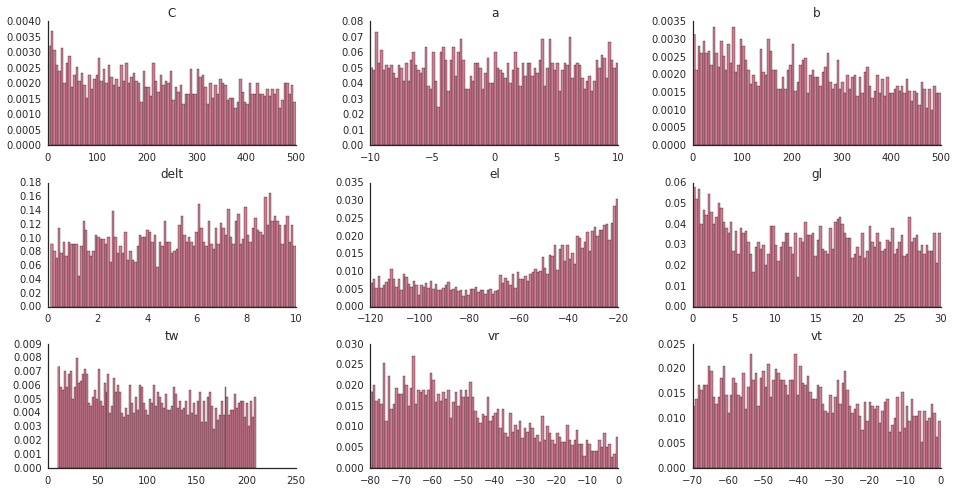

In [6]:
# load plotting packages
from matplotlib.pyplot import * # plotting package
import seaborn as sns          # data visualization package
import pandas as pd            # data analysis and manipulation package

# tell IPython to show plots in the notebook
%matplotlib inline

# set up the plots to look not awful
clr_plt = sns.color_palette('cubehelix',4)
sns.set_style('white')

# put the MCMC trace into nice and tidy dataframe
mcmc_samples = pd.DataFrame(sampler.flatchain, columns = ["C", "gl", "el", "delt", "vt", "tw", "a", "vr", "b"])
mcmc_samples = np.round(mcmc_samples,2)

# plot a histogram of samples
hists = mcmc_samples.hist(bins=100,color=clr_plt[2],figsize=(16, 8),normed=True,grid='off')
jointHist = np.histogram2d(sampler.flatchain[:,1],sampler.flatchain[:,3], bins = 300)

# remove ugly and useless spines
sns.despine()

In [10]:
## Initializing probability distributions for each paramter to be input into lnprior
import numpy as np


countsC, binsC = np.histogram(mcmc_samples.C, range = (1,500), bins = 1996) ## sets up real, usable histogram
countsC += 1
probsC = countsC.astype(float)/np.sum(countsC) 




countsgl, binsgl = np.histogram(mcmc_samples.gl, range = (0,30), bins =500) ## sets up real, usable histogram
countsgl += 1
probsgl = countsgl.astype(float)/np.sum(countsgl)  ## divides entire array by sum of counts, giving individual probabilities




countsel, binsel = np.histogram(mcmc_samples.el, range = (-120,20), bins =560) ## sets up real, usable histogram
countsel += 1
probsel = countsel.astype(float)/np.sum(countsel) 




countsdelt, binsdelt = np.histogram(mcmc_samples.delt, range = (.1, 10), bins =400) ## sets up real, usable histogram
countsdelt += 1
probsdelt= countsdelt.astype(float)/np.sum(countsdelt) 


glP = np.log(probsgl[(np.digitize([gl], binsgl))-1]) 
CP =  np.log(probsC[(np.digitize([C], binsC))-1])
elP =  np.log(probsel[(np.digitize([el], binsel))-1]) 
deltP =  np.log(probsdelt[(np.digitize([delt], binsdelt))-1])

np.save('glP_file', glP, delimiter=',')   
np.save('CP_file', CP, delimiter=',')
np.save('elP_file', elP, delimiter=',')
np.save('deltP_file', deltP, delimiter=',')
        





In [127]:
index = np.digitize([-1],bins)
index, counts[-1]

(array([0]), 1)

In [22]:
# get the median parameter values from the posterior distribution
mean = np.asarray(mcmc_samples.mean())
med = np.asarray(mcmc_samples.median())
mod = np.asarray(mcmc_samples.mode())[0]
best = sampler.flatchain[sampler.flatlnprobability.argmax()]

mC, mgl, mel, mdelt, mvt, mtw, ma, mvr, mb = best

print(" Parameter means:")
print(np.round(mean,2))
print("\n Parameter medians:")
print(med)
print("\n Parameter modes:")
print(mod)
print("\n Parameter bests:")
print(np.round(best,2))

 Parameter means:
[  2.37460000e+02   1.47700000e+01  -5.47100000e+01   5.40000000e+00
  -3.83200000e+01   1.01350000e+02   1.10000000e-01  -4.81800000e+01
   2.28060000e+02]

 Parameter medians:
[  2.33420000e+02   1.42250000e+01  -4.34800000e+01   5.61000000e+00
  -4.11600000e+01   9.89300000e+01   1.25000000e-01  -5.10900000e+01
   2.22570000e+02]

 Parameter modes:
[ 67.13   4.71 -24.32   1.64 -62.23  14.88   2.1  -77.73  12.36]

 Parameter bests:
[  21.83    8.84  -27.5     7.68   -4.35  126.55    5.83  -75.08  461.19]


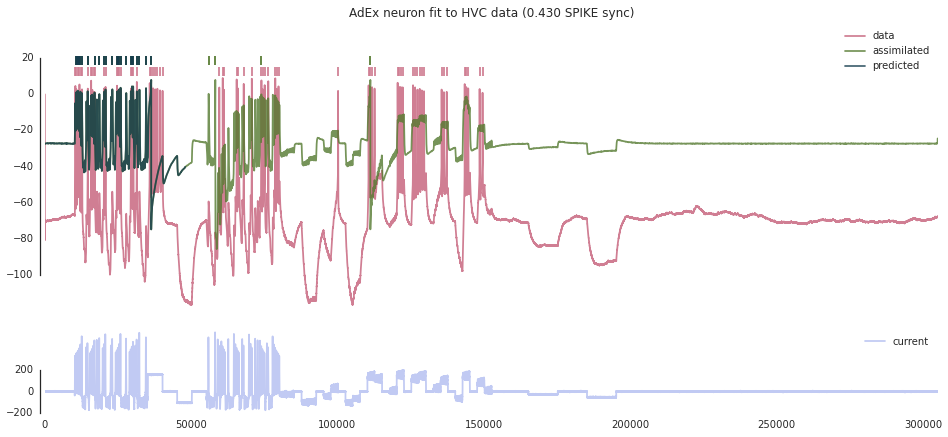

In [23]:
# integrate the model using the estimated parameters
bn = cn.adex(mC, mgl, mel, mdelt, mvt, mtw, ma, mvr, mb)
bn.h = 8
bn.apply_current(iapp_all,res)
zz = bn.simulate(allduration,dt)[:,0]

# get the spike times produced by the model
zspikes = det.send(zz)
zaspikes = det.send(zz[:steps])
zs = spk.SpikeTrain(zspikes,[0,allduration])

# set up a nice, wide canvas 
frame = figure(figsize=(16,7))

# plot the voltage traces of the real neuron and model
subplot2grid((4,1),(0,0),rowspan=3)
plot(v_all,color=clr_plt[2],label='data')
plot((zz),color=clr_plt[1],alpha=0.8,label='assimilated')
plot(((zz[:steps])),color=clr_plt[0],alpha=0.8,label='predicted')
xlim((0,len(v_all)))

# mark the spike times
vlines(vallspikes,max(v_all)+1,max(v_all)+6,color=clr_plt[2])
vlines(zspikes,max(v_all)+7,max(v_all)+12,clr_plt[1])
vlines(zaspikes,max(v_all)+7,max(v_all)+12,clr_plt[0])

# apply various aesthetic enhancements
xticks([0],[''])
yticks(range(-100,21,20))

legend(loc="best")

title("AdEx neuron fit to HVC data (%.3f SPIKE sync)" % spk.spike_sync(zs,vas))

# plot the applied current
subplot2grid((4,1),(3,0),rowspan=1)

plot(iapp_all,label='current',color=clr_plt[3])
legend(loc="best")
yticks(range(-200,400,200))
xlim((0,(len(v_all)*dt)/res))

# kill the spines
sns.despine(trim=True,offset=5,bottom=True)

In [41]:
'''
modspikes = []
dspikes = []
for s in zspikes:
    if s > steps:
        modspikes.append(s)

for s in vallspikes:
    if s > steps:
        dspikes.append(s)
        
MODEL = spk.SpikeTrain(modspikes,[0,allduration])
DATA = spk.SpikeTrain(dspikes,[0,allduration])

print(spk.spike_sync(MODEL,DATA,max_tau=maxtau))
'''

0.377358490566


In [55]:
##TEST CELL
'''
s = np.random.uniform(2,10,10)
s
'''

array([ 9.39260176,  9.83699812,  6.72981839,  7.02693227,  6.65464614,
        9.49454337,  2.74852514,  2.79923229,  9.19213374,  9.84630554])